In [108]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import torch 
import torch.nn as nn
import os
import shutil
from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 


In [109]:
file_path_train = base_dir + '/semantic-segmentation/data/train/_annotations.coco.json'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/_annotations.coco.json'   
file_paht_test = base_dir + '/semantic-segmentation/data/test/_annotations.coco.json'

# Doc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

with open(file_paht_test, 'r') as file:
    data_test = json.load(file) 


In [110]:
categories_train = data_train['categories']
images_train = data_train['images']
annotations_train = data_train['annotations']

categories_valid = data_valid['categories']
images_valid = data_valid['images']
annotations_valid = data_valid['annotations']

categories_test = data_test['categories']
images_test = data_test['images']
annotations_test = data_test['annotations'] 




In [111]:
def create_maskGt(segmentations, input_image):
    """ 
    Create a mask from a list of segmentations.

    Args:
        segmentations: A list of segmentation polygons.
        input_image: The input image.

    Returns:
        A binary mask as a NumPy array.
    """
    mask = np.zeros((input_image.height, input_image.width), dtype=np.uint8)
    
    for seg in segmentations:
        poly = np.array(seg).reshape((-1, 2))
        img_poly = Polygon(poly)
        x, y = np.meshgrid(np.arange(input_image.width), np.arange(input_image.height))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x, y)).T

        path = img_poly.get_path()
        grid = path.contains_points(points)
        grid = grid.reshape((input_image.height, input_image.width))
        mask[grid] = 1

    return mask


In [112]:
import matplotlib.pyplot as plt

def visualize_masks(image, mask_gt, mask_pred_classic, mask_pred_finetune, figsize=(15, 15)):
    """
    Visualizes two masks side-by-side, along with the original image.

    Args:
        image: The original image.
        mask_gt: The ground truth mask.
        mask_gd: The predicted mask.
        figsize: The size of the figure.
    """

    # Create a new figure with three subplots.
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot the ground truth mask on the second subplot.
    axes[0].imshow(image)
    axes[0].imshow(mask_gt, alpha =0.5)
    axes[0].set_title("Ground Truth Mask")

    # Plot the predicted mask on the third subplot.
    axes[1].imshow(image)
    axes[1].imshow(mask_pred_classic, alpha =0.5)
    axes[1].set_title("Predicted Mask Classic")
    # Plot the predicted mask on the third subplot.
    axes[2].imshow(image)
    axes[2].imshow(mask_pred_finetune, alpha =0.5)
    axes[2].set_title("Predicted Mask Finetune")

    # Show the figure.
    plt.show()

In [113]:
file_path_train = base_dir + '/semantic-segmentation/data/train/'
file_path_valid = base_dir + '/semantic-segmentation/data/valid/'
file_path_test = base_dir + '/semantic-segmentation/data/test/'

"""
# Debug opening images : encountering No file found for .jpg
for image in images_train:
    image_path = os.path.join(file_path_train + image['file_name'])
    try: 
        with Image.open(image_path) as image_file:
            # Process the image
            pass 

    except FileNotFoundError as e:
        print(f"Error opening image: {image_path}")
        print(e)
"""

'\n# Debug opening images : encountering No file found for .jpg\nfor image in images_train:\n    image_path = os.path.join(file_path_train + image[\'file_name\'])\n    try: \n        with Image.open(image_path) as image_file:\n            # Process the image\n            pass \n\n    except FileNotFoundError as e:\n        print(f"Error opening image: {image_path}")\n        print(e)\n'

In [114]:
# For debugging purposes
"""
imgs_train = []
for image in images_train:
    imgs_train.append(Image.open(file_path_train + image['file_name']))

msks_train = []
for i in range(len(imgs_train)):
    image_obj = imgs_train[i]
    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)
    msks_train.append(mask)
    """

"\nimgs_train = []\nfor image in images_train:\n    imgs_train.append(Image.open(file_path_train + image['file_name']))\n\nmsks_train = []\nfor i in range(len(imgs_train)):\n    image_obj = imgs_train[i]\n    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)\n    msks_train.append(mask)\n    "

In [115]:


imgs_train = []
for image in images_train:
    imgs_train.append(Image.open(file_path_train + image['file_name']))

msks_train = []
for i in range(len(imgs_train)): 
    image_obj = imgs_train[i]       
    mask = create_maskGt(annotations_train[i]['segmentation'], image_obj)
    msks_train.append(mask)

imgs_val = []
for image in images_valid:
    imgs_val.append(Image.open(file_path_valid + image['file_name']))

msks_val = []
for i in range(len(imgs_val)):
    image_obj = imgs_val[i]
    mask = create_maskGt(annotations_valid[i]['segmentation'], image_obj)
    msks_val.append(mask)

imgs_test = []
for image in images_test:
    imgs_test.append(Image.open(file_path_test + image['file_name']))

msks_test = []
for i in range(len(imgs_test)):
    image_obj = imgs_test[i]
    mask = create_maskGt(annotations_test[i]['segmentation'], image_obj)
    msks_test.append(mask)

print(len(imgs_train))
print(len(msks_train))
print(len(imgs_val))
print(len(msks_val))
print(len(imgs_test))
print(len(msks_test))



1502
1502
429
429
215
215


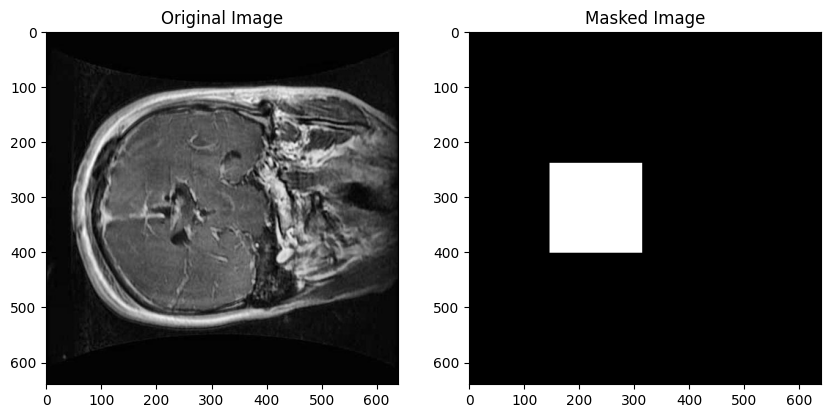

In [116]:
# Plot the original image
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imgs_train[0])
plt.title('Original Image')

# Plot the mask
plt.subplot(1,2,2)
plt.imshow(msks_train[0], cmap='gray')
plt.title('Masked Image')

plt.show()